## Лабораторная 7: логические алгоритмы. Бустинг

### Попробуем применить самые сильные на сегодняшний день композиции логических алгоритмов к рассмотренной в лабораторной работе 3 задаче о Титанике. Загрузите данные и подключите необходимые библиотеки:

In [117]:
import numpy as np
import pandas as pd
import warnings
from sklearn import *

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [120]:
data = pd.read_csv('data.csv');
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## 1
### Замените неизвестные значения и создайте новый сильный признак — приставка к имени (Mr, Mrs, Miss)

In [121]:
data.Age.fillna(-1, inplace=True)
data.Cabin.fillna('unknown', inplace=True)
data.Embarked.fillna('unknown', inplace=True)
data['NamePrefix'] = data.Name.apply(lambda s: 'Mr' 
                                     if s.find('Mr.')>=0 else 'Mrs' 
                                     if s.find('Mrs.')>=0 else 'Miss' 
                                     if s.find('Miss.')>=0 else 'None')

In [122]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NamePrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,unknown,S,None
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-1.0,1,2,W./C. 6607,23.4500,unknown,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


## 2

### Закодируйте номинальные признаки числовыми значениями:

In [123]:
columns = ['Survived','Pclass','NamePrefix','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
data1 = data.loc[:, columns].copy(deep=True).reset_index(drop=True)
le = preprocessing.LabelEncoder()
for c in ['NamePrefix', 'Sex', 'Cabin', 'Embarked']:
    data1[c] = le.fit_transform(data1[c])


## 3

### В лабораторной работе 3 довольно много студентов с помощью элементарного и неточного метода ближайших соседей достигли точности больше 84%. Примените самые мощные на сегодняшний день алгоритмы `RandomForest`, `CatBoost` от Yandex, `xgboost`, `LightGBM` от Microsoft, основанные на бустинге деревьев. При необходимости настройте их так, чтобы все показали качество больше 83%. Для сравнения выведите на экран лучшую точность работы одного классифицирующего дерева:

In [124]:
# генератор разбиений обучающей выборки на train и test
cv = model_selection.KFold(n_splits=6, shuffle=True, random_state=0)

In [125]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Tree = tree.DecisionTreeClassifier(max_depth=12, random_state=37, min_samples_split = 6,  criterion='entropy')
    bagging = ensemble.BaggingClassifier(base_estimator=Tree, random_state=10, n_estimators=50)
    prediction = model_selection.cross_val_predict(bagging, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Tree: {:6.4}'.format(acc))

    RandomForest = ensemble.RandomForestClassifier(n_estimators=130, max_depth=10)
    prediction = model_selection.cross_val_predict(RandomForest, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Random forest: {:6.4}'.format(acc))

    XGBoost = xgb.XGBClassifier()
    prediction = model_selection.cross_val_predict(XGBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('XGBoost: {:6.4}'.format(acc))

    LightGBM = lgb.LGBMClassifier(verbosity=-1)
    prediction = model_selection.cross_val_predict(LightGBM, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('LightGBM: {:6.4}'.format(acc))

    CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.025)
    prediction = model_selection.cross_val_predict(CatBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('CatBoost: {:6.4}'.format(acc))

Tree: 0.8305
Random forest: 0.8339
[21:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:34] WARNING: C:/Users/Admini

## 4

### В комментариях попытайтесь объяснить парадокс, почему перечисленные выше супер алгоритмы не смогли победить метод ближайших соседей из 3-й лабораторной работы?

In [ ]:
#Ну я евляюсь обладателем самого точного knn в потоке, и CatBoost более точным получился ) В моем случае порадокса нет, 
# но я думаю что у тех людей у кого knn работал лучше, получился он из за переобучения knn, 
# поскольку мы подбирали коэфиценты хоть и опираясь  на тествою вэборку но все же, произошло перееобучение, и обобщающая 
# спосбность хуже у knn, если вдруг появится второй титаник ))) Так что крутые алгоритмы более унивирсальные 

##  5
### Найдите 10 самых информативных признаков, при помощи следующего подхода. Используйте по очереди каждый признак, чтобы по нему предсказать ответ. Нарисуйте на графике столбцовую диаграмму качества предсказаний

In [126]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for c in data1.columns:
    if c == 'Survived': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data1[c].values.reshape(-1,1),
                                                       data1['Survived'],
                                                       cv=cv)
    importance[c] = metrics.accuracy_score(data1['Survived'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)

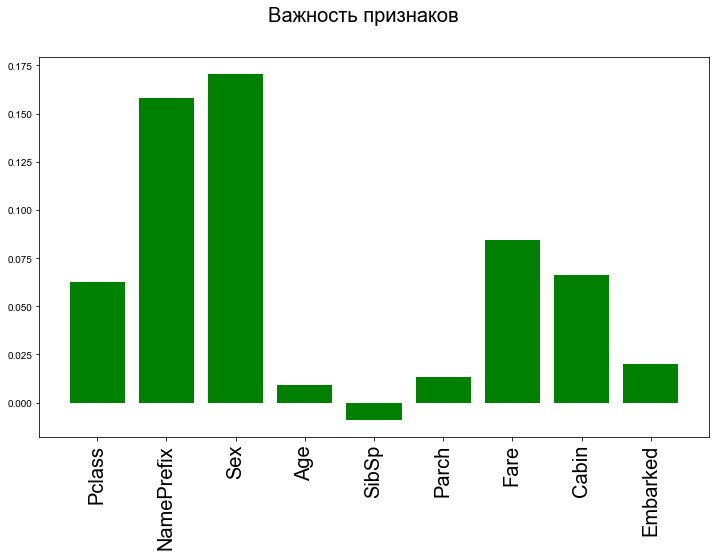

In [127]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols)), fi, color='g')
plt.xticks(np.arange(len(cols)), cols, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

Ну тут из графика и так все видно


## 6
### Судя по графику самыми важными являются признаки пола и приставки к имени. Переберите все возможные пары признаков и выясните, является ли эта пара признаков наилучшей. Выведите на экран 10 лучших пар по убывнию их важности

In [138]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}

for i, one in enumerate(data1.columns):
    if one == 'Survived': continue
    for j, two in enumerate(data1.columns):
        if two == 'Survived' or j<=i: continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prediction = model_selection.cross_val_predict(method, 
                                                        data1[[one, two]],
                                                        data1['Survived'],
                                                        cv=cv)
        importance[one+' ' +two] = metrics.accuracy_score(data1['Survived'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)
for j, i in enumerate(cols):
    importance[i]=fi[j]

In [139]:

sorted_keys = sorted(importance, key=importance.get)[::-1] 
tmp = np.array([importance[c] for c in sorted_keys[:10]])
#print(tmp)

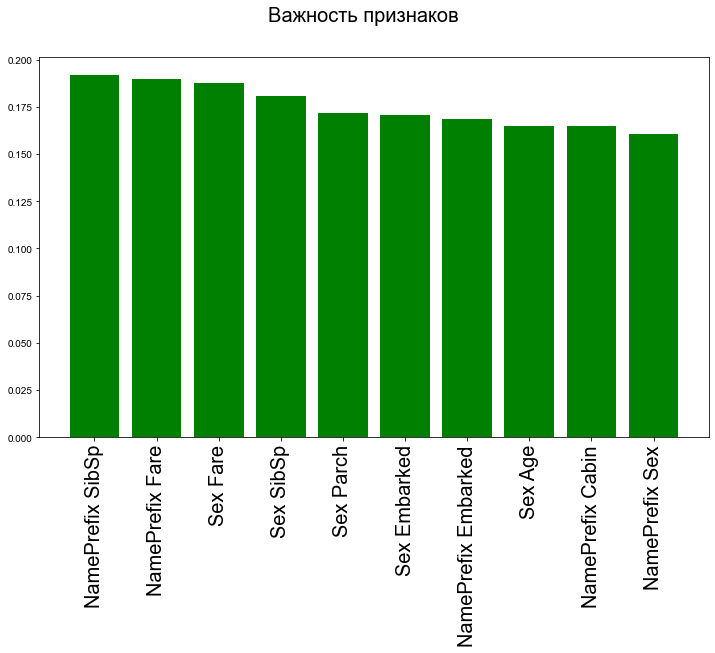

In [140]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(sorted_keys[:10])), tmp, color='g')
plt.xticks(np.arange(len(sorted_keys[:10])), sorted_keys[:10], rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

10 Лудших видны на графике
